# Annotating Cell Types

This workbook can be run after the standard workflow.
It is demonstrating how to use the  annotation function to annotate the dataset that was runned through the standard worflow.

In this notebook, we will show how to use in-besca annotation to assign cell type to clusters.
We focus on immune celltype and demonstrate signature-scoring functions.


An alternative in the case a an annotated training dataset already exists is to use the auto-annot module. Please refer to the corresponding tutorial.

In [ ]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
import logging
import seaborn as sns
sc.logging.print_versions()

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

In [2]:
#define standardized filepaths based on above input
root_path = os.getcwd()
bescapath_full = os.path.dirname(bc.__file__)
bescapath = os.path.split(bescapath_full)[0]

### Uncomment this when running after the standard workflow
analysis_name = 'standard_workflow_besca2'

clusters='leiden'


The chunk of code below is usefull if this is the initial installation of besca and that you are running this notebook as a test. It will download if needed the test datasets and export the labelling. 
This export is usually done at the end of the standard workflow. Exported files  are necessary for the annotations.

In [ ]:
use_example_dataset = True
if use_example_dataset:
    analysis_name='pbmc3k_processed'
    results_folder = os.path.split(os.getcwd())[0] + '/besca/datasets/data/'
    clusters='leiden'
    # This line will either download, or load the datasets
    adata = bc.datasets.pbmc3k_processed()
    # This line exports the annotation for the annotation.
    adata = bc.st.additional_labeling(adata, labeling_to_use= clusters, labeling_name = clusters, 
                                      labeling_description = 'Exporting a postori the labels for annotation',
                                      labeling_author = 'Testing', 
                                      results_folder= results_folder)
else:
    results_folder = os.path.join(root_path, 'analyzed', analysis_name)
    adata = sc.read_h5ad(os.path.join(results_folder, analysis_name + '.h5ad') )

In [23]:
results_file = os.path.join(results_folder, analysis_name + '.annotated.updated.h5ad')
figdir=os.path.join(root_path, 'analyzed', analysis_name+'/figures/')
sc.settings.figdir = figdir
if not os.path.exists(figdir):
    os.makedirs(figdir)

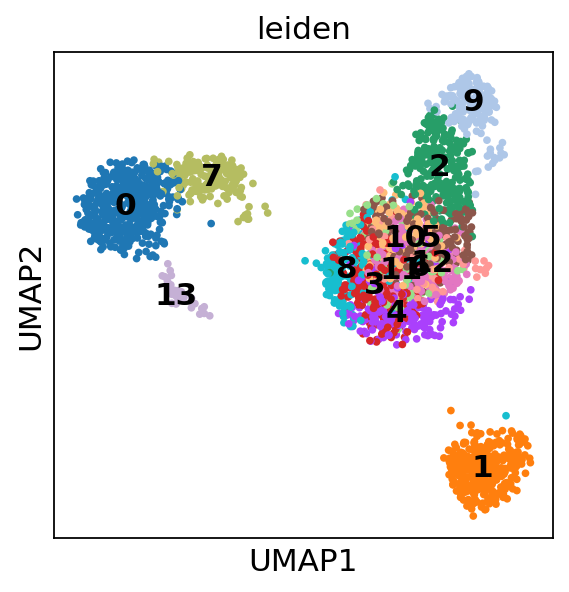

In [6]:
sc.pl.umap(adata, color= [clusters], legend_loc='on data')

### Explore top marker genes per cluster 

In [7]:
DEgenes=bc.tl.dge.get_de(adata,clusters,demethod='wilcoxon',topnr=5000, logfc=1,padj=0.05)


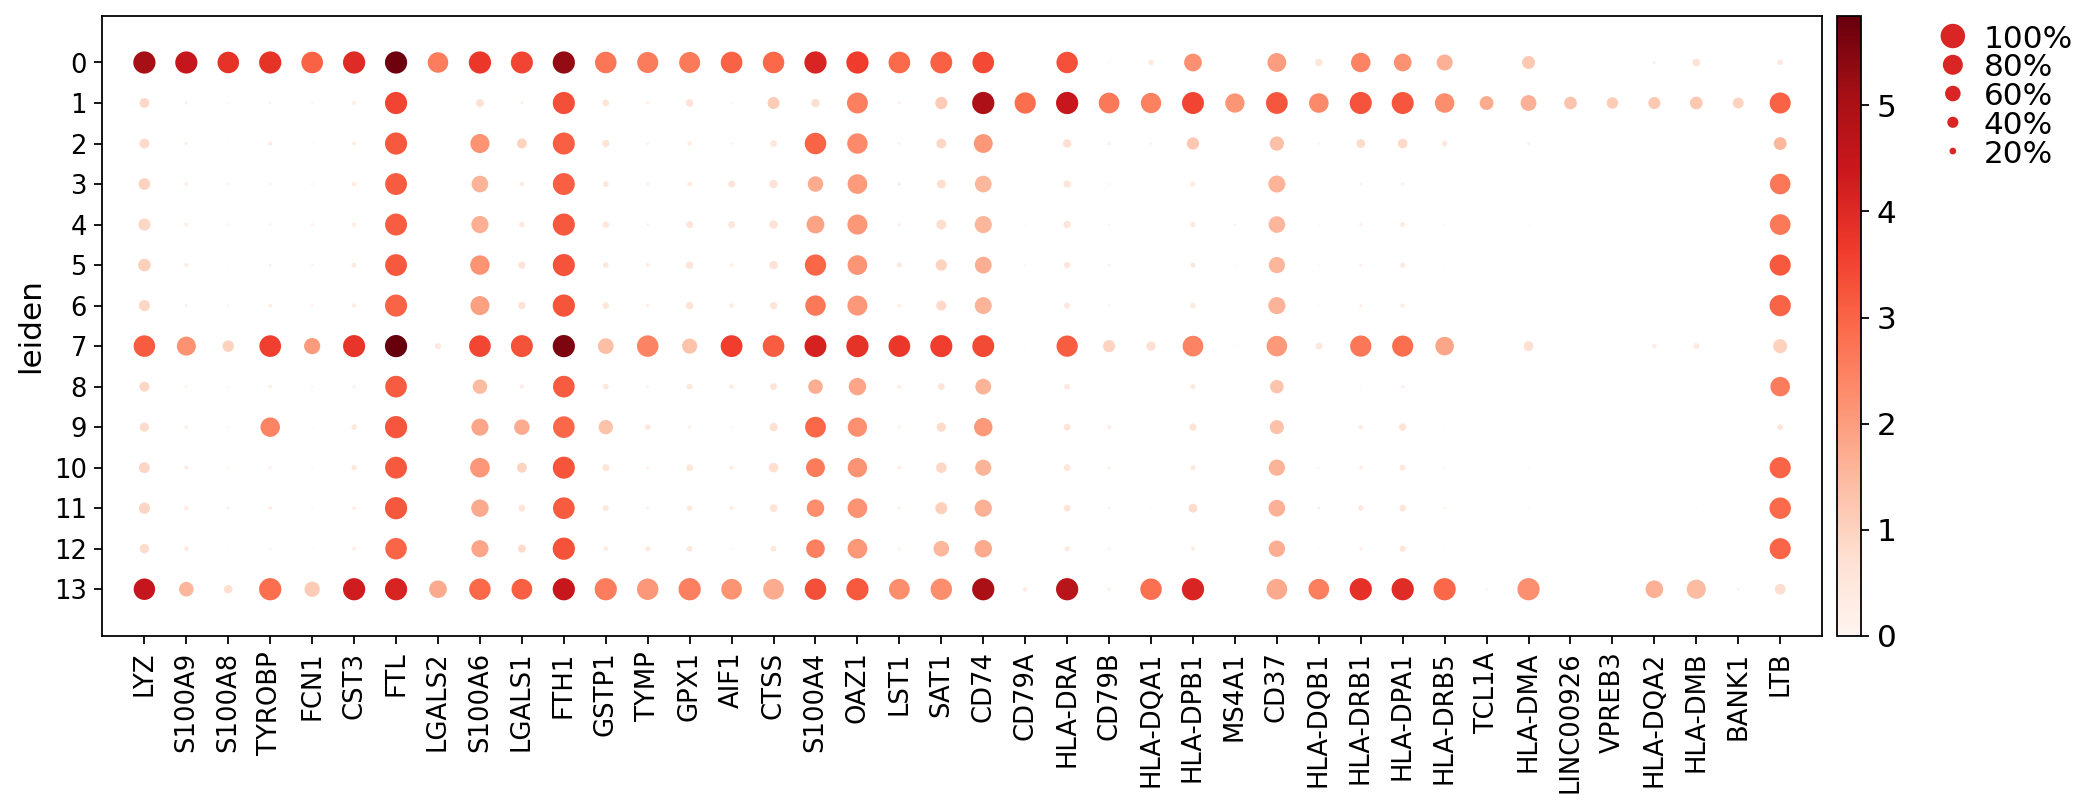

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[14.0, 0, 0.2, 0.5, 0.25])

In [8]:
### Select only top genes (in order of p-val) for 2 clusters and plot expression per cluster
tops=list(DEgenes['0']['Name'][0:20])+list(DEgenes['1']['Name'][0:20])
sc.pl.dotplot(adata, var_names=tops,groupby=clusters)

### Explore distribution of various cell populations

In [9]:
# One can load besca-provided signatures using the function below
signature_dict = bc.datasets.load_immune_signatures(refined=False)

signature_dict

{'lymphocyte': ['PTPRC'],
 'myeloid': ['S100A8', 'S100A9', 'CST3'],
 'Bcell': ['CD19', 'CD79A', 'MS4A1'],
 'Tcells': ['CD3E', 'CD3G', 'CD3D'],
 'CD4': ['CD4'],
 'CD8': ['CD8A', 'CD8B'],
 'NKcell': ['NKG7', 'GNLY', 'NCAM1'],
 'monocyte': ['CST3', 'CSF1R', 'ITGAM', 'CD14', 'FCGR3A', 'FCGR3B'],
 'macrophage': ['CD14',
  'IL1B',
  'LYZ    CD163   ITGAX',
  'CD68',
  'CSF1R',
  'FCGR3A']}

Additionaly it is possible to read an compute scanpy score using this function below.

If the gmt file is composed of combined signature (UP and DN), a common score will be computed: 
$$Total\_SCORE= Score_{UP} - Score_{DN}$$

In [10]:

gmt_file= bescapath + '/besca/datasets/genesets/Immune.gmt'
bc.tl.sig.combined_signature_score(adata, gmt_file,
                             UP_suffix='_UP', DN_suffix='_DN', method='scanpy',
                             overwrite=False, verbose=False,
                             use_raw=True, conversion=None)

In [11]:
scores = [x for x in adata.obs.columns if 'scanpy' in x]

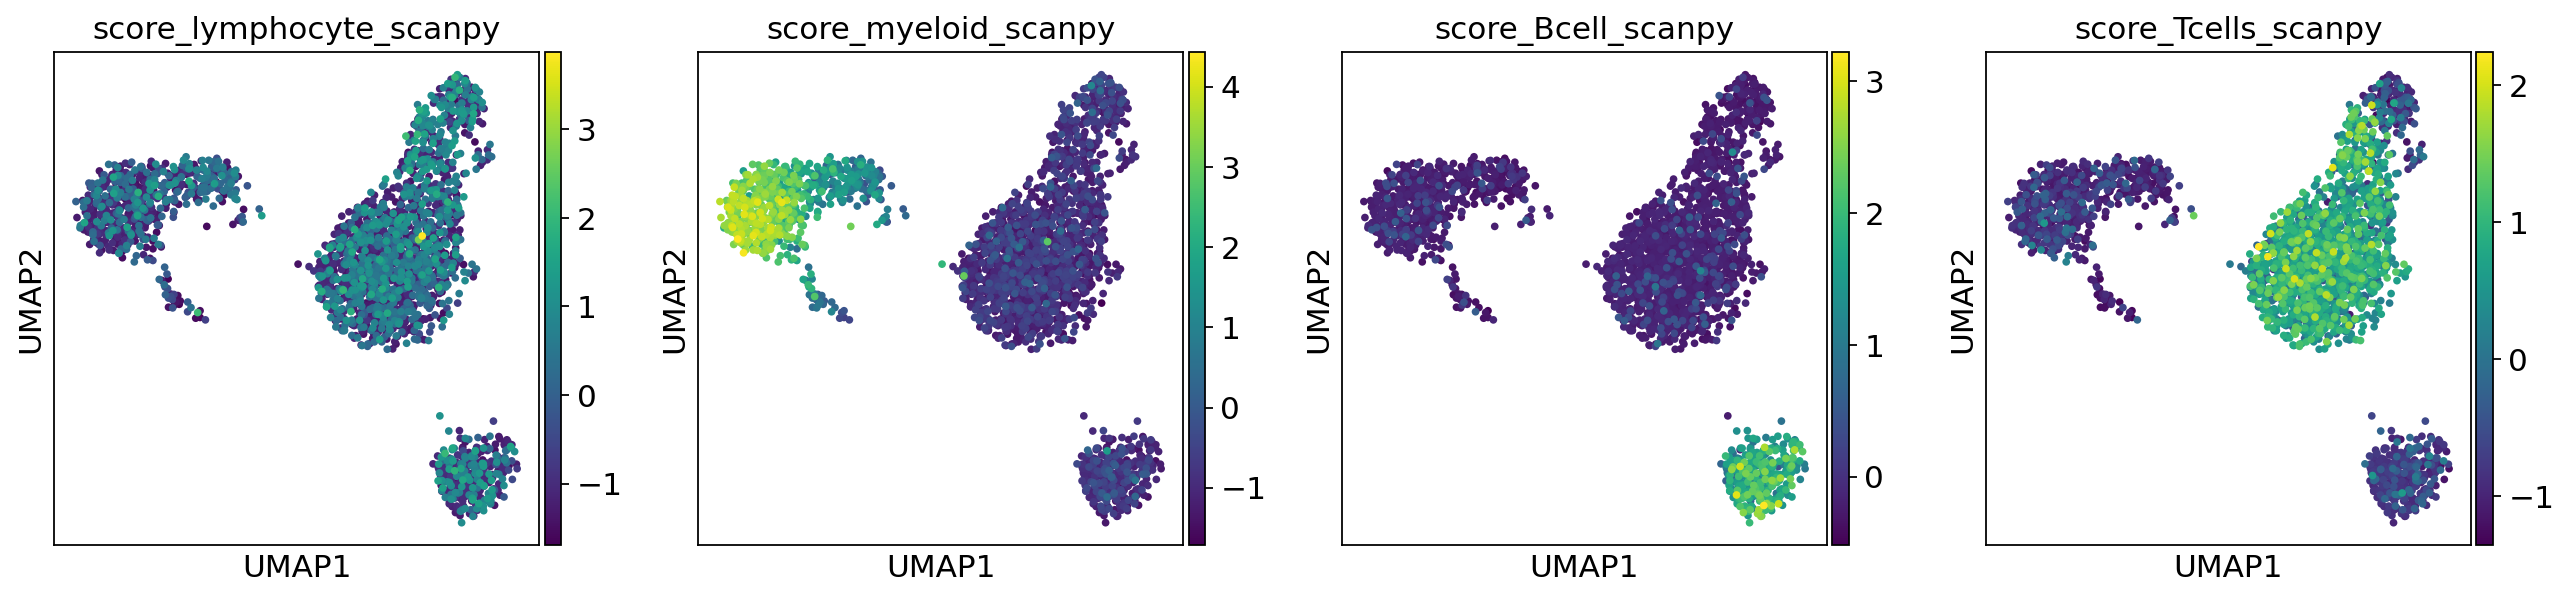

In [72]:
sc.pl.umap(adata, color= scores)

# Immune signatures for specific sub-populations

In [13]:
 ## PROVIDED WITH BESCA
gmt_file_anno= bescapath + '/besca/datasets/genesets/CellNames_scseqCMs6_sigs.gmt'
bc.tl.sig.combined_signature_score(adata, gmt_file_anno)


In [ ]:
scores = [x for x in adata.obs.columns if 'scanpy' in x]
sc.pl.umap(adata, color= scores, color_map = 'viridis')

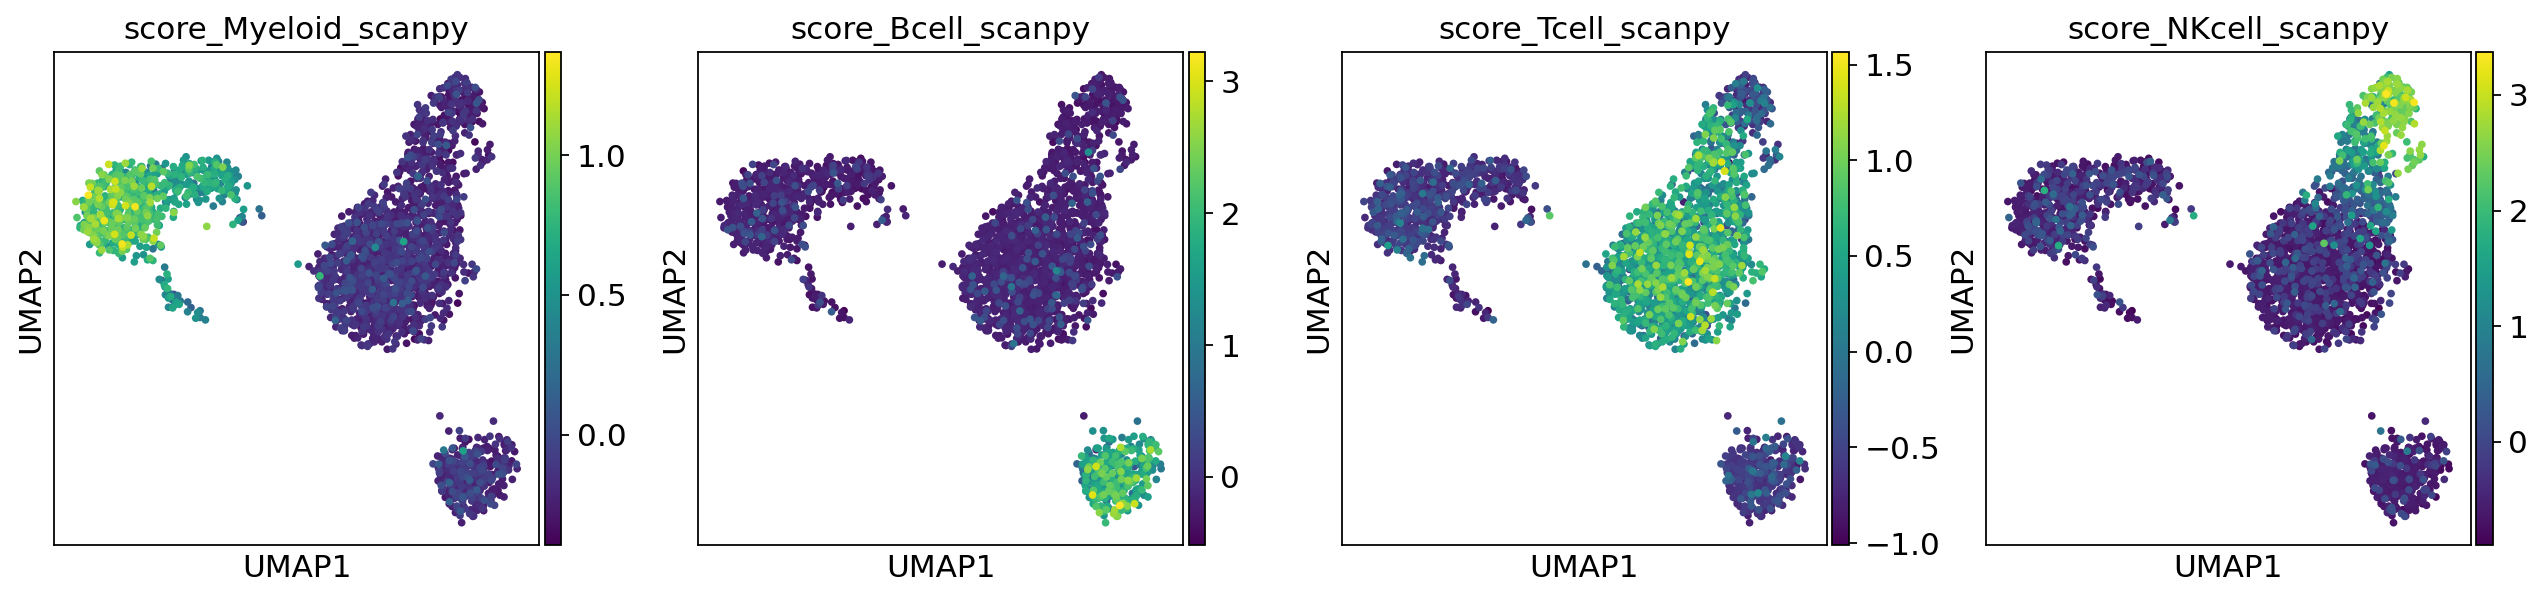

In [75]:
sc.pl.umap(adata, color= ['score_Myeloid_scanpy','score_Bcell_scanpy','score_Tcell_scanpy','score_NKcell_scanpy'], color_map = 'viridis')

# Automated annotation

A decision-tree-based annotation that reads signatures from a provided .gmt file and hierarchy as well as cutoffs and signature ordering from a configuration file and attributes each cell to a specific type according to signature enrichment. 

This is an aid to start ther annotation and annotation can then be further refined by adding further signatures or adjusting the configuration files. It was tested mainly on PBMCs and oncology (tumor biopsies) related samples.


## Loading markers and signature

In [15]:
mymarkers = bc.tl.sig.read_GMT_sign(gmt_file_anno,directed=False)
mymarkers = bc.tl.sig.filter_siggenes(adata, mymarkers) ### remove genes not present in dataset or empty signatures
mymarkers['Ubi'] = ['B2M','ACTB', 'GAPDH'] ### used for cutoff adjustment to individual dataset, can be modified

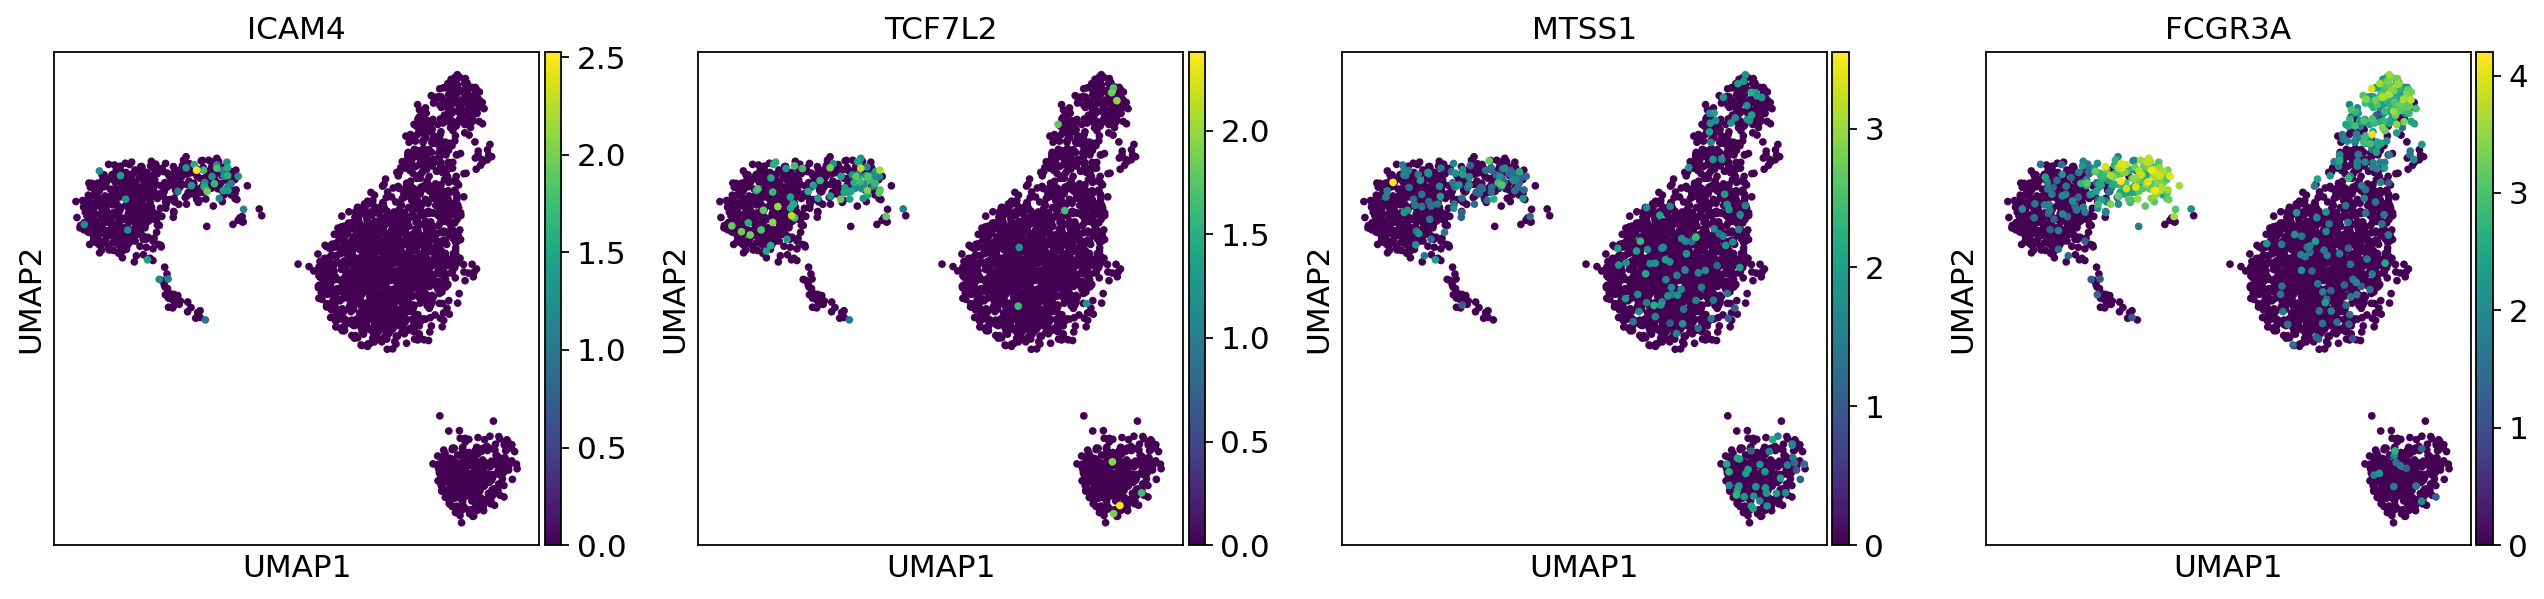

In [16]:
### Inspect gene expression for an example population
sc.pl.umap(adata, color= mymarkers['NClassMonocyte'])

## Configuration of the annotation

We read the configuration file, containing hierarchy, cutoff and signature priority information. 
A new version of this file should be created and maintained with each annotation. 
The included example is optimised for the annotation of the 6.6k PBMC dataset. 

In [17]:
configfile=bescapath + '/besca/datasets/genesets/CellNames_scseqCMs6_config.tsv' ### replace this with your config

In [18]:
sigconfig,levsk=bc.tl.sig.read_annotconfig(configfile)

In [ ]:
# The order of cells at different levels can be manually changed if needed
#levsk[0]=['ColorectalCancer', 'Epithelial','Fibroblast','Endothelial','Erythrocyte','HematoStem',
#          'Hepatocyte','MelMelanoma','Neural','Adipocyte','Hematopoietic','Schwann','Chondrocyte','Glial']

#### Get an overview of the cell type hierarchy included in the configuration file

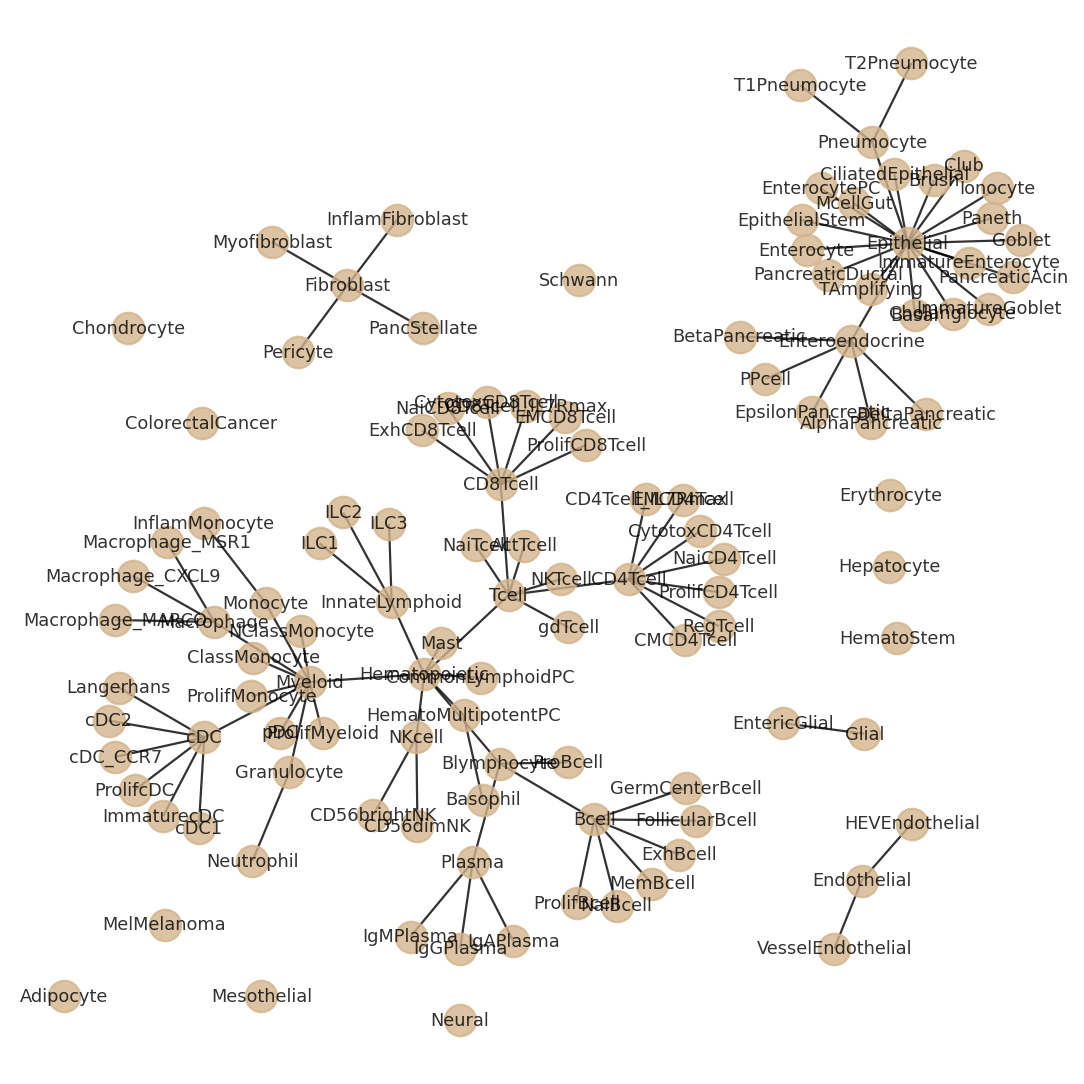

In [24]:
plt=bc.pl.nomenclature_network(configfile, font_size=8)
plt.savefig(figdir+"Nomenclatureplot.svg", format="svg")

Fract_pos was exported by BESCA in the standard worflow test, 
contains information of fraction positive cells per genes per cluster.

We use these values as a basis for a wilcoxon test per signature per cluster. 

In [25]:

f=pd.read_csv(results_folder + "/labelings/"+clusters+"/fract_pos.gct",sep="\t",skiprows=2)
df=bc.tl.sig.score_mw(f,mymarkers)
myc=np.median(df.loc['Ubi',:]*0.5) ### Set a cutoff based on Ubi and scale with values from config file


In [26]:
df.iloc[0:3,0:7]

,10,7,4,5,13,11,3
Bcell,3.33179,7.80649,9.34424,2.43838,7.80042,2.75612,4.45114
Fibroblast,0.305675,1.19473,0.389146,0.102357,0.290622,0.331313,0.384737
Endothelial,0.534654,9.77757,0.997747,0.386012,6.4328,0.781705,0.354419


#### For an overview of highest scoring signatures, one can generate a heatmap

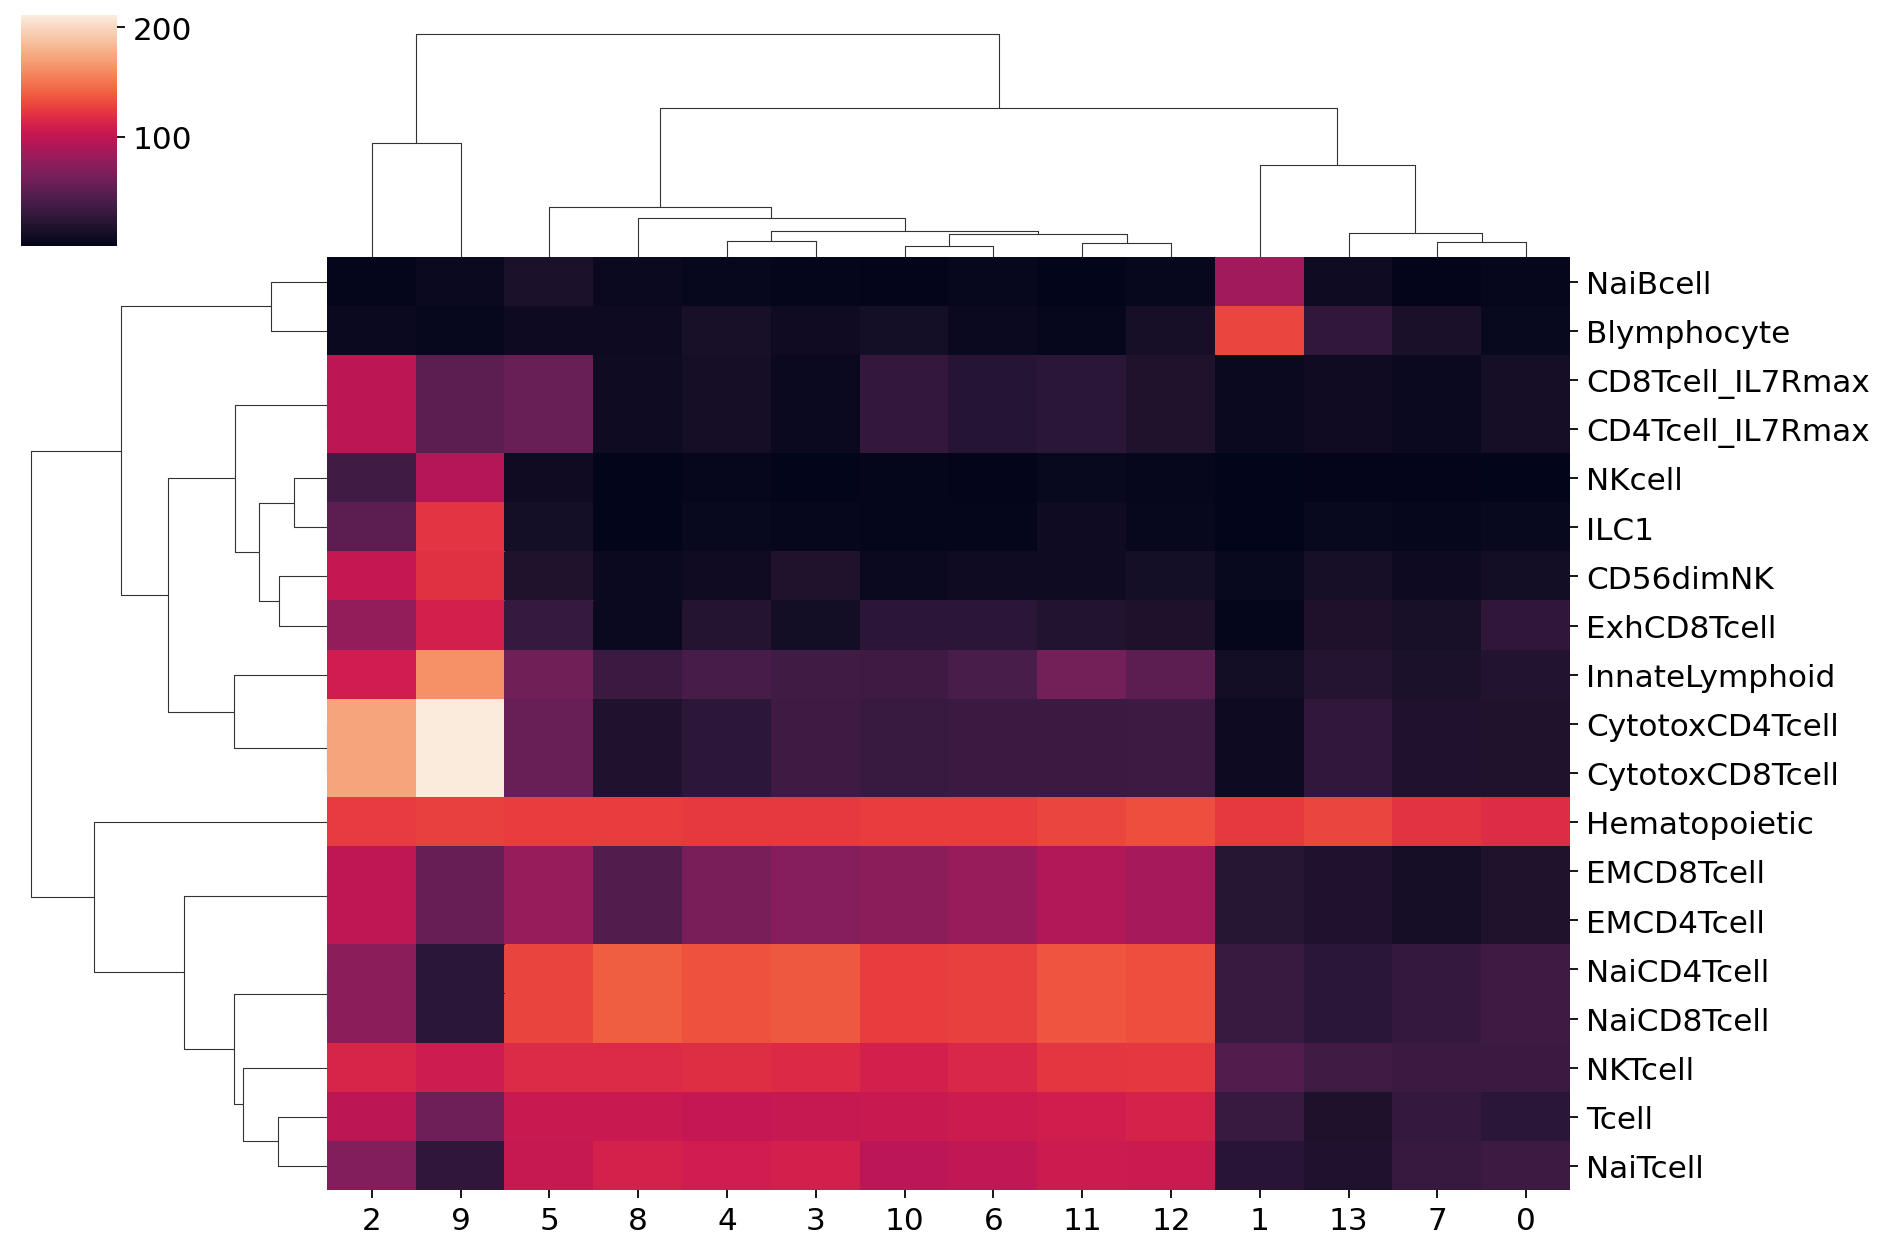

In [31]:
sns.clustermap(df.loc[df.max(axis=1)>myc*2.5,:].astype(float),figsize=(12, 8))
plt.savefig(figdir+"SignatureHeatmap_all.svg", format="svg")

For each signature, positive and negative clusters are determined. Only positive clusters are maintained. Cutoffs can be individualised based on the config file (scaling factor) and myc, which is determined based on ubiquitously expressed genes. 

In [ ]:
df=df.drop('Ubi')

In [ ]:
# Cutoffs can also be manually adjusted if needed 
# sigconfig.loc['Epithelial','Cutoff']=1.5


In [32]:
#Cluster attribution based on cutoff

sigscores={}
for mysig in list(df.index):
    sigscores[mysig]=bc.tl.sig.getset(df,mysig,sigconfig.loc[mysig,'Cutoff']*myc)
    #sigscores[mysig]=bc.tl.sig.getset(df,mysig,10)

One can inspect the cluster attribution per cell type in the signature list and adjust cutoffs as required. 

In [82]:
sigscores

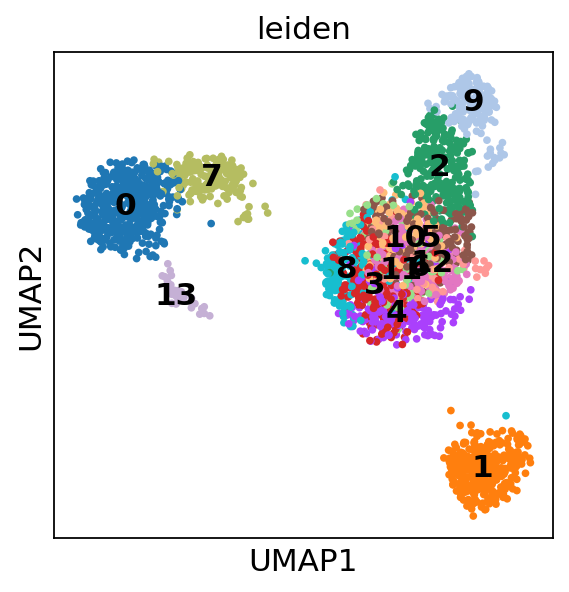

In [34]:
sc.pl.umap(adata, color= [clusters], legend_loc='on data')

Now each cluster gets annotated, according to the distinct levels specified in the config file. 
Note that in case a cluster is positive for multiple identities, only the first one is taken, 
in the order specified in the "Order" column in the config file. 

To check the given order, per levels, you can inspect levsk, and adjust above as needed

In [81]:
levsk

## Obtained cluster assignment

In [36]:
### Cell types that are not expected in the dataset can be explicity excluded from the annotation 
toexclude=['Erythrocyte','AlphaPancreatic', 'BetaPancreatic', 'DeltaPancreatic']


In [37]:
cnames=bc.tl.sig.make_anno(df,sigscores,sigconfig,levsk, toexclude=toexclude)

We now obtained per each cluster cell type attribution at distinct levels. 

In [38]:
cnames

,celltype0,celltype1,celltype2,celltype3
10,Hematopoietic,Tcell,CD4Tcell,NaiCD4Tcell
7,Hematopoietic,Myeloid,NClassMonocyte,NClassMonocyte
4,Hematopoietic,Tcell,CD8Tcell,NaiCD8Tcell
5,Hematopoietic,Tcell,CD8Tcell,EMCD8Tcell
13,Hematopoietic,Myeloid,cDC,cDC2
11,Hematopoietic,Tcell,CD8Tcell,NaiCD8Tcell
3,Hematopoietic,Tcell,CD8Tcell,NaiCD8Tcell
8,Hematopoietic,Tcell,CD8Tcell,NaiCD8Tcell
12,Hematopoietic,Tcell,CD4Tcell,NaiCD4Tcell
2,Hematopoietic,Tcell,CD8Tcell,CytotoxCD8Tcell


Export the used annotation parameters, for future reference

In [39]:
bc.tl.sig.export_annotconfig(sigconfig, levsk, results_folder, analysis_name)

## Using db label convention

Only short names were used in the signature naming convention in this case. 
One can easity tranform this to EFO terms if preferred, a conversion table comes with besca. 

This nomenclature is quite extended, and the function 
**obtain_dblabel** can perform the conversion.

In [40]:
### transform these short forms to dblabel - EFO standard nomenclature
cnamesDBlabel = bc.tl.sig.obtain_dblabel(bescapath+'/besca/datasets/nomenclature/CellTypes_v1.tsv', cnames )
cnamesDBlabel

,celltype0,celltype1,celltype2,celltype3
10,hematopoietic cell,T cell,"CD4-positive, alpha-beta T cell","naive thymus-derived CD4-positive, alpha-beta ..."
7,hematopoietic cell,myeloid leukocyte,non-classical monocyte,non-classical monocyte
4,hematopoietic cell,T cell,"CD8-positive, alpha-beta T cell","naive thymus-derived CD8-positive, alpha-beta ..."
5,hematopoietic cell,T cell,"CD8-positive, alpha-beta T cell","effector memory CD8-positive, alpha-beta T cell"
13,hematopoietic cell,myeloid leukocyte,myeloid dendritic cell,CD1c-positive myeloid dendritic cell
11,hematopoietic cell,T cell,"CD8-positive, alpha-beta T cell","naive thymus-derived CD8-positive, alpha-beta ..."
3,hematopoietic cell,T cell,"CD8-positive, alpha-beta T cell","naive thymus-derived CD8-positive, alpha-beta ..."
8,hematopoietic cell,T cell,"CD8-positive, alpha-beta T cell","naive thymus-derived CD8-positive, alpha-beta ..."
12,hematopoietic cell,T cell,"CD4-positive, alpha-beta T cell","naive thymus-derived CD4-positive, alpha-beta ..."
2,hematopoietic cell,T cell,"CD8-positive, alpha-beta T cell","CD8-positive, alpha-beta cytotoxic T cell"


Finally, one can add the new labels to adata.obs as annotation. 

In [41]:
adata.obs['celltype0']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype0',clusters)
adata.obs['celltype2']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype2',clusters)
adata.obs['celltype3']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype3',clusters)

In [80]:
sc.pl.umap(adata,color=['celltype2']) #,'celltype2'

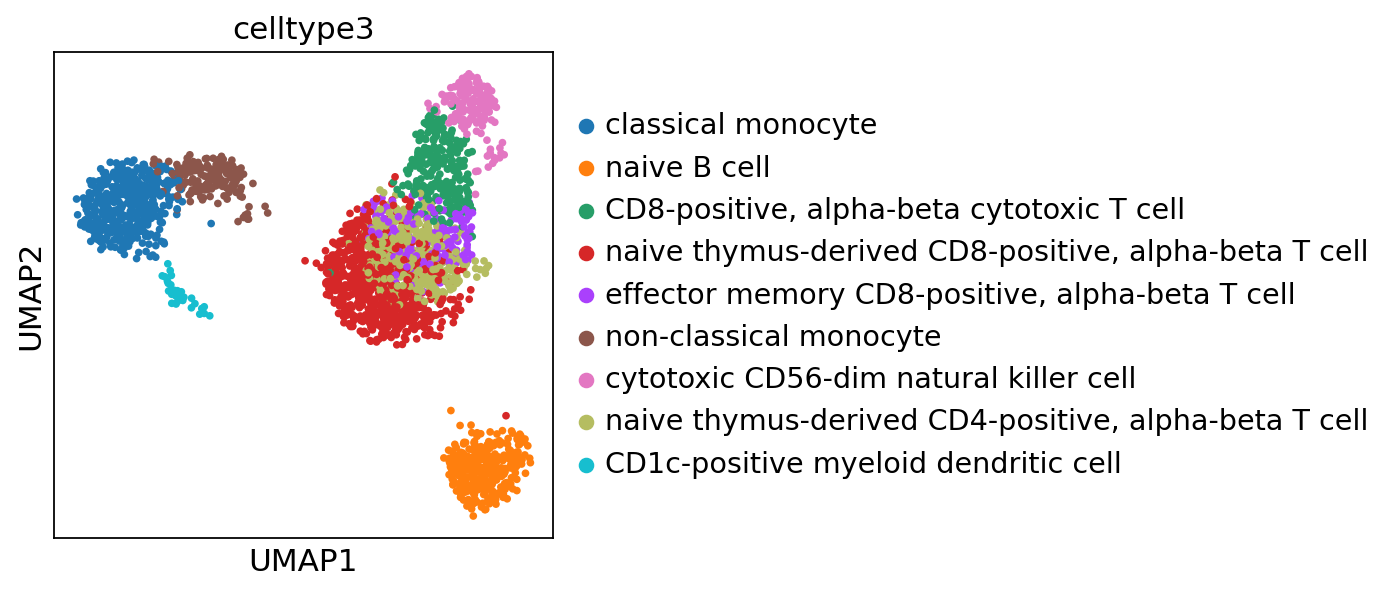

In [43]:
sc.pl.umap(adata,color=['celltype3']) #,'celltype3'

## Manual refinement

In some cases, the annotation does not produce the optimal result. Manual adjustments can be made, 
by replacing cell type names or by manually labeling clusters. Note that the second option is not 
stable across reruns if any adjustments are made to the clustering. 

In [45]:
### Example 1: Classical monocytes contains both classical and non-classical monocytes, adjust to monocytes
#adata.obs['celltype2']=list(adata.obs['celltype2'].replace('classical monocyte', 'monocyte'))
#adata.obs['celltype3']=list(adata.obs['celltype3'].replace('classical monocyte', 'monocyte'))

In [46]:
### Example 2: non-classical monocytes need to be added to a specific cluster
#adata.obs['celltype2']=adata.obs['celltype2'].cat.add_categories('non-classical monocyte')
#adata.obs['celltype3']=adata.obs['celltype3'].cat.add_categories('non-classical monocyte')
#adata.obs.loc[adata.obs[clusters].isin(['4']),'celltype2']='non-classical monocyte'
#adata.obs.loc[adata.obs[clusters].isin(['4']),'celltype3']='non-classical monocyte'

# Reclustering sub-clusters 

Sometimes, clusters appears to be of mix cells type. For example, for PBM3K, the lymphocyte clusters are mixed.  In this case, one can try to increase clustering resolution or recluster specifically on those clusters.
Below we show an example.

The main steps are:
+ saving previous clustering and annotation for comparison purpose (advised)
+ recluster 
+ Export the new labelling (see function additional_labeling)
+ Read the new labelling information including fract_pos files.
+ Recompute signatures/markers values
+ Reannotate
+ Convert annotation to dblabel
+ Export all for the data subset to the larger adata object.

In [47]:
recluster = False

if use_example_dataset:
    recluster = True
    celltype_label = 'celltype2_original'
    to_recluster =  ('CD8-positive, alpha-beta T cell','CD4-positive, alpha-beta T cell',
                                         'cytotoxic CD56-dim natural killer cell')

In [ ]:
if recluster:
    # Save previous clustering obtained for comparision
    adata.obs['leiden_original'] = adata.obs['leiden'].copy()
    adata.obs['celltype2_original']  = adata.obs['celltype2'].copy() 

    # Calling reclustering
    adata_rc = bc.tl.rc.recluster ( adata, celltype_label = celltype_label, 
                               celltype=to_recluster, resolution=1.3)
    # Leiden reclustering have to be exported to use the annotation function 
    cluster_renamed = 'Leiden_Reclustering'
    adata_rc = bc.st.additional_labeling(adata_rc, 'leiden', cluster_renamed, 'Leiden Reclustering on Lymphocytes', 'author', results_folder)
   
    # Reading additional labelling
    f=pd.read_csv(results_folder + "/labelings/"+cluster_renamed+"/fract_pos.gct",sep="\t",skiprows=2)
    df=bc.tl.sig.score_mw(f,mymarkers)
    myc=np.median(df.loc['Ubi',:]*0.5) ### Set a cutoff based on Ubi and scale with values from config file

    # RECOMPUTING SIG SCORE WITH NEW CUTOFF
    df=df.drop('Ubi')
    sigscores={}
    for mysig in list(df.index):
        sigscores[mysig]=bc.tl.sig.getset(df,mysig,sigconfig.loc[mysig,'Cutoff']*myc)

    # Adjust cutoffs if needed
    # sigconfig.loc['Epithelial','Cutoff']=1.5
    
    cnames=bc.tl.sig.make_anno(df,sigscores,sigconfig,levsk, toexclude=toexclude)
    cnamesDBlabel = bc.tl.sig.obtain_dblabel(bescapath+'/besca/datasets/nomenclature/CellTypes_v1.tsv', cnames )
    
    adata_rc.obs['celltype0']=bc.tl.sig.add_anno(adata_rc,cnamesDBlabel,'celltype0','leiden')
    adata_rc.obs['celltype2']=bc.tl.sig.add_anno(adata_rc,cnamesDBlabel,'celltype2','leiden')
    adata_rc.obs['celltype3']=bc.tl.sig.add_anno(adata_rc,cnamesDBlabel,'celltype3','leiden')
    # Lex orrder needed.
    names_2 = []
    names_3 = []
    for i in range( cnames.shape[0]) :
        names_2 += [cnames['celltype2'][str(i)]]
        names_3 += [cnames['celltype3'][str(i)]]
    
    bc.tl.rc.annotate_new_cellnames( adata, adata_rc, names = names_2, new_label='celltype2', method = 'leiden')

    bc.tl.rc.annotate_new_cellnames( adata, adata_rc, names = names_3, new_label='celltype3', method = 'leiden')
    
    sc.pl.umap(adata,color=['celltype2', 'celltype2_original',
                       'celltype3'], ncols=1) 

### Export labelling

Chosen labels can also be exported as a new folder in labelings/

In [ ]:
### Save labelling
adata = bc.st.additional_labeling(adata, 'celltype3', 'celltype3', 'Major cell types attributed based on HumanCD45p_scseqCMs8', 'schwalip', results_folder)


### Follow-up analyses for marker generation

If one is interested in new markers, one can perform DE at the cell type annotation level of choice. 

In [51]:
### Perform DE cells of each celltype3 vs. all other cells
DEgenes=bc.tl.dge.get_de(adata,'celltype3',demethod='wilcoxon',topnr=5000, logfc=1,padj=0.05)

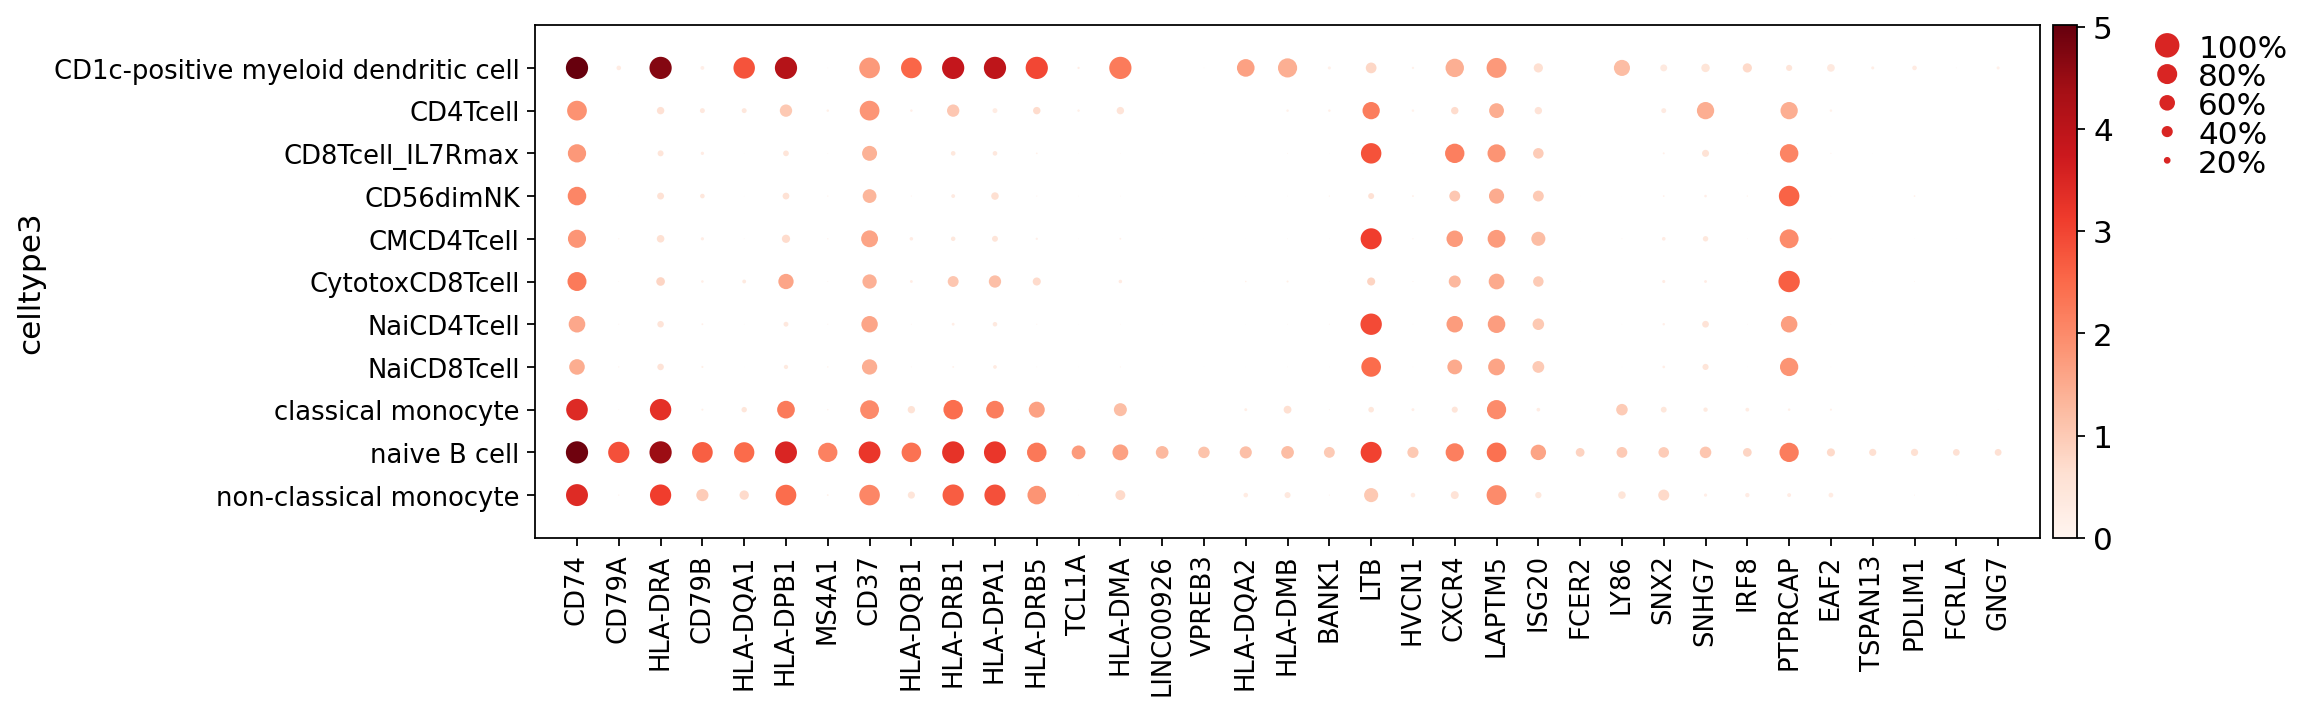

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[12.25, 0, 0.2, 0.5, 0.25])

In [54]:
### Select only top 15 genes (in order of p-val) for 2 cell types and plot expression per cell type
tops=list(DEgenes['naive B cell']['Name'][0:35])
sc.pl.dotplot(adata, var_names=tops,groupby='celltype3')

If one is interested in additional markers correlated with the marker of interest, 
one can caculated the spearman correlation. 

In [69]:
import scipy.stats as ss
import operator

allmarkers=adata.var_names

spearcorsAll = {}
for i in allmarkers:
    spearcorsAll[i]=ss.spearmanr(adata.raw[:, i].X.todense(),adata.raw[:,'MS4A1'].X.todense())[0]


spearcorsAll=sorted(spearcorsAll.items(),key=operator.itemgetter(1))
spearcorsAll_ids = [idx for idx, val in spearcorsAll]
goiNegAll=spearcorsAll_ids[0:30]
goiPosAll=spearcorsAll_ids[(len(spearcorsAll_ids)-30):len(spearcorsAll_ids)]

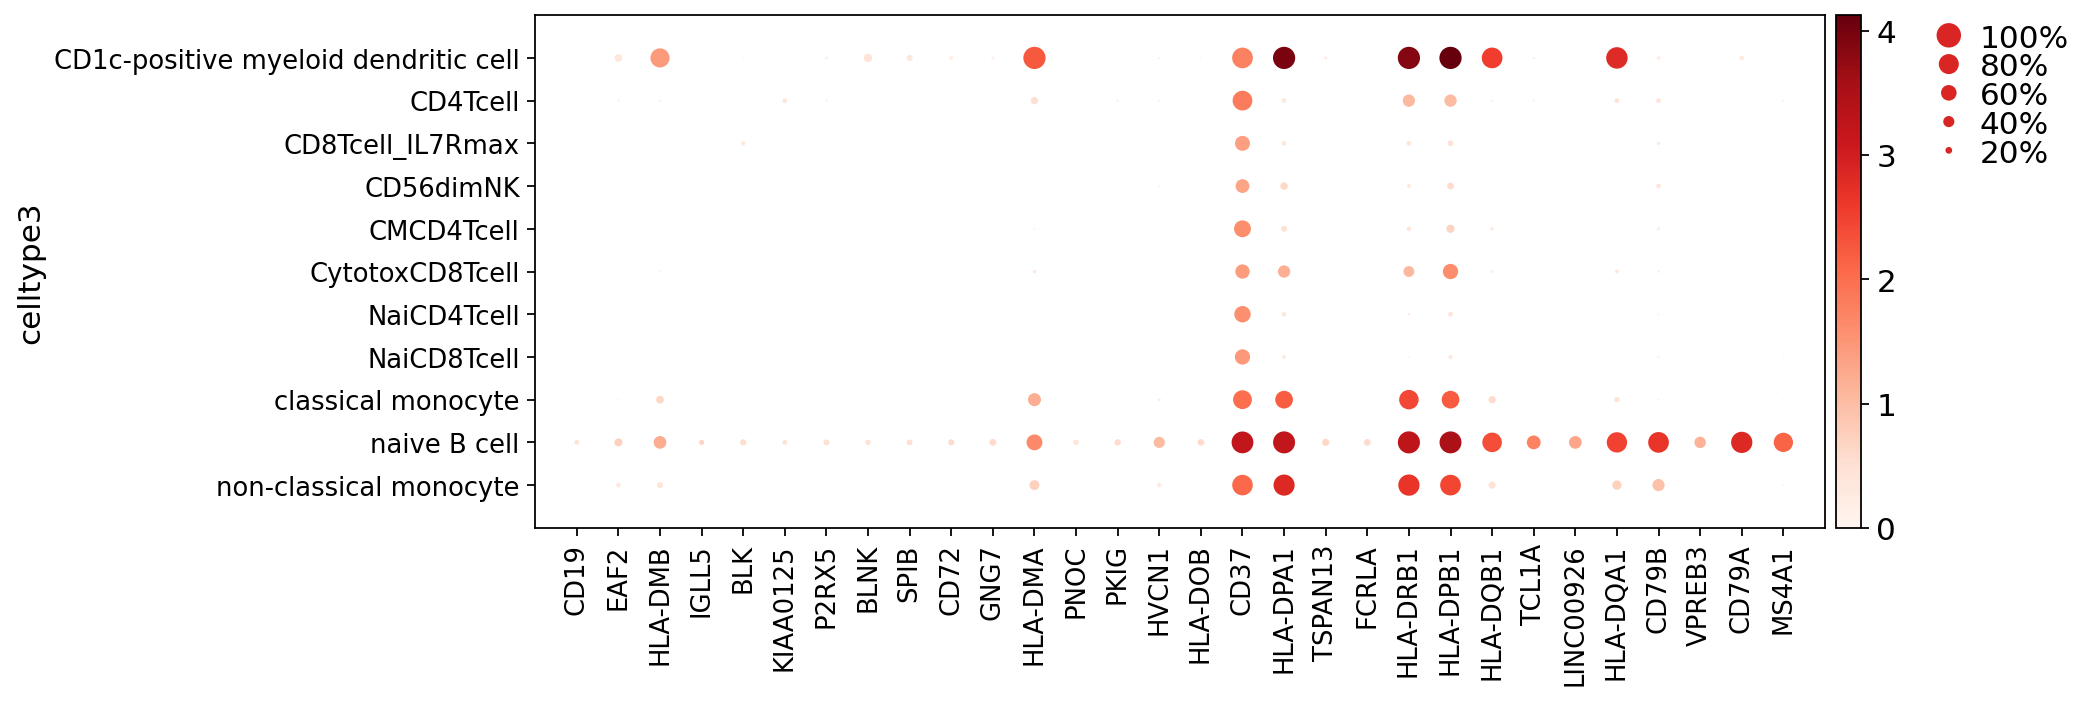

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[10.5, 0, 0.2, 0.5, 0.25])

In [70]:
sc.pl.dotplot(adata, var_names=goiPosAll,groupby='celltype3')

### Convert to html

In [83]:
! jupyter nbconvert --to html celltype_annotation_besca.ipynb

[NbConvertApp] Converting notebook celltype_annotation_besca.ipynb to html
[NbConvertApp] Writing 3313609 bytes to celltype_annotation_besca.html
